<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Forest Emissions Tracking - Validation

_CarbonPlan ClimateTrace Team_

This notebook compares our estimates of country-level forest emissions to prior
estimates from other groups. The notebook currently compares againsts:

- Global Forest Watch (Zarin et al. 2016)
- Global Carbon Project (Friedlingstein et al. 2020)


In [1]:
import geopandas
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import awswrangler
from carbonplan_styles.mpl import set_theme
from carbonplan_styles.colors import dark
import math
set_theme()

In [2]:
# Input data
# ----------

# country shapes from GADM36
countries = geopandas.read_file(
    "s3://carbonplan-climatetrace/inputs/shapes/countries.shp"
)

# CarbonPlan's emissions
emissions = {}
versions = [ 'v0.3', 'v0.4'] #'v0.1',
for version in versions:
#     try:
#         emissions[version] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions.csv".format(version))
#     except:
#         emissions[version] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups.csv".format(version))
# #         continue

    for mechanism in ['fire', 'clearing']:
        emissions[version+'-'+mechanism] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions_from_{}.csv".format(version, mechanism))
        emissions[version+'-'+mechanism] = emissions[version+'-'+mechanism].rename({'tCO2eq': 'GtCO2'}, axis=1)
        if version == 'v0.4':
            # v0.4 is now in tons but we'll be working in gt here
            emissions[version+'-'+mechanism]['GtCO2'] /= 1e9
    if version =='v0.4':
        emissions[version] = pd.read_csv("s3://carbonplan-climatetrace/{}/country_rollups_emissions.csv".format(version))
        emissions[version] = emissions[version].rename({'tCO2eq': 'GtCO2'}, axis=1)
        emissions[version]['GtCO2'] /= 1e9
    else:
        emissions[version] = emissions[version+'-fire'].copy(deep=True)
        emissions[version]['GtCO2'] = emissions[version+'-fire']['GtCO2']+emissions[version+'-clearing']['GtCO2']
# GFW emissions
gfw_emissions = pd.read_excel(
    "s3://carbonplan-climatetrace/validation/gfw_global_emissions.xlsx",
    sheet_name="Country co2 emissions",
).dropna(axis=0)
gfw_emissions = gfw_emissions[
    gfw_emissions["threshold"] == 10
]  # select threshold

# Global Carbon Project
gcp_emissions = (
    pd.read_excel(
        "s3://carbonplan-climatetrace/validation/Global_Carbon_Budget_2020v1.0.xlsx",
        sheet_name="Land-Use Change Emissions",
        skiprows=28,
    )
    .dropna(axis=1)
    .set_index("Year")
)
gcp_emissions *= 3.664  # C->CO2
gcp_emissions.index = [
    pd.to_datetime(f"{y}-01-01") for y in gcp_emissions.index
]
gcp_emissions = gcp_emissions[["GCB", "H&N", "BLUE", "OSCAR"]]

# Blue Sky Fire emissions
emissions['Blue Sky'] = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/forest-fires_bsa.csv")

# all the inventories
inventories_df = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/210623_all_inventory_data.csv")

harris = awswrangler.s3.read_json("s3://carbonplan-scratch/harris-emmissions/country-rollups.json")

In [3]:
# Merge emissions dataframes with countries GeoDataFrame
gfw_countries = countries.merge(
    gfw_emissions.rename(columns={"country": "name"}), on="name"
)
trace_countries = {}
for version in versions:
    trace_countries[version] = countries.merge(
        emissions[version].rename(columns={"iso3_country": "alpha3"}), on="alpha3"
    )
    for mechanism in ['fire', 'clearing']:
        trace_countries[version+'-'+mechanism] = countries.merge(
            emissions[version+'-'+mechanism].rename(columns={"iso3_country": "alpha3"}), on="alpha3"
        )

In [4]:
def long_to_wide(df):
    df = df.drop(columns=["end_date"]).pivot(index="begin_date", 
                                             columns="iso3_country").droplevel(0, axis=1)
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
# reformat to "wide" format (time x country)
trace_wide = {}
for version in emissions.keys():
    if version != 'Blue Sky':
        trace_wide[version] = long_to_wide(emissions[version])
gfw_wide = (
    gfw_emissions.set_index("country")
    .filter(regex="whrc_aboveground_co2_emissions_Mg_.*")
    .T
)
gfw_wide /= 1e9
gfw_wide.index = [pd.to_datetime(f"{l[-4:]}-01-01") for l in gfw_wide.index]

In [6]:
cols = 6
rows = len(bad_countries) // cols + 1
fig, axarr = plt.subplots(len(bad_countries))
for i, country in enumerate(countries):
    trace_wide[country].plot(ax=axarr[i])
    (trace_wide['v0.4-fire'][country]+trace_wide['v0.4-clearing'][country]).plot(ax = axarr[i])

NameError: name 'bad_countries' is not defined

## Part 1 - Compare time-averaged country emissions


In [7]:
# Create a new dataframe with average emissions
avg_emissions = countries.set_index("alpha3")
for version in trace_wide.keys():
    avg_emissions[version] = trace_wide[version].mean().transpose()
avg_emissions['alpha3'] = avg_emissions.index
avg_emissions = avg_emissions.set_index("name")
avg_emissions["gfw"] = gfw_wide.mean().transpose()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


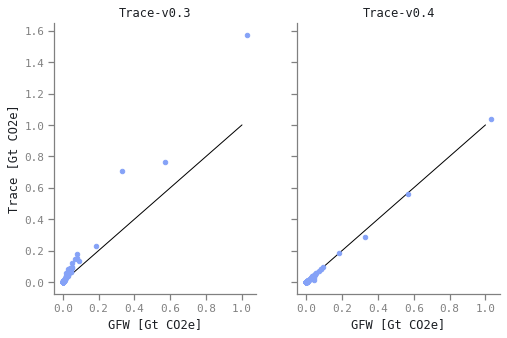

In [8]:
# Scatter Plot
fig, axarr = plt.subplots(ncols=2, sharey=True, figsize=(8,5))
for i, version in enumerate(versions):
    axarr[i].plot([0, 1], [0,1], 'k-', lw=1, zorder=0)
    avg_emissions.plot.scatter("gfw", version, ax=axarr[i])
    axarr[i].set_ylabel("Trace [Gt CO2e]")
    axarr[i].set_xlabel("GFW [Gt CO2e]")
    axarr[i].set_title("Trace-{}".format(version))


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


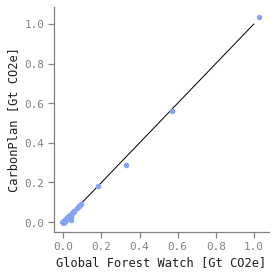

In [20]:
# Scatter Plot
fig, axarr = plt.subplots(figsize=(4,4))
axarr.plot([0, 1], [0,1], 'k-', lw=1, zorder=0)
avg_emissions.plot.scatter("gfw", version, ax=axarr)
axarr.set_ylabel("CarbonPlan [Gt CO2e]")
axarr.set_xlabel("Global Forest Watch [Gt CO2e]")
plt.tight_layout()
plt.savefig('gfw_scatter.png')

## Part 2 - Comparing with 2001-2020 average emissions from GFW

In [10]:
avg_emissions_nonan = avg_emissions.dropna()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


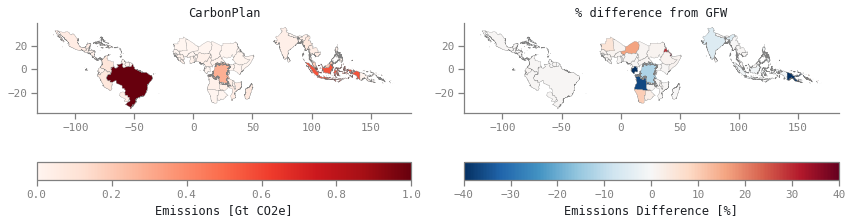

In [12]:
fig, axarr = plt.subplots(ncols=2, figsize=(12,5))
kwargs = dict(
    legend=True,
    legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
    lw=0.25,
    cmap="Reds",
    vmin=0,
    vmax=1,
    ax=axarr[0]
)
avg_emissions_nonan.plot("{}".format(version), **kwargs)
axarr[0].set_title("CarbonPlan".format(version))

kwargs = dict(
legend=True,
legend_kwds={
    "orientation": "horizontal",
    "label": "Emissions Difference [%]",
},
lw=0.25,
cmap="RdBu_r",
vmin=-40,
vmax=40,
ax=axarr[1]
)
avg_emissions_nonan["pdiff"] = (
    (avg_emissions_nonan['v0.4'] - avg_emissions_nonan["gfw"])
    / avg_emissions_nonan["gfw"]
) * 100
avg_emissions_nonan.plot("pdiff", **kwargs)
axarr[1].set_title("% difference from GFW")
    
plt.tight_layout()
plt.savefig('gfw_map.png')

## Part 3 - Compare with timeseries of tropical country emissions from GFW

In [13]:
avg_emissions_nonan['country'] = avg_emissions_nonan.index
tropical_countries = avg_emissions_nonan[['alpha3', 'country']].values

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


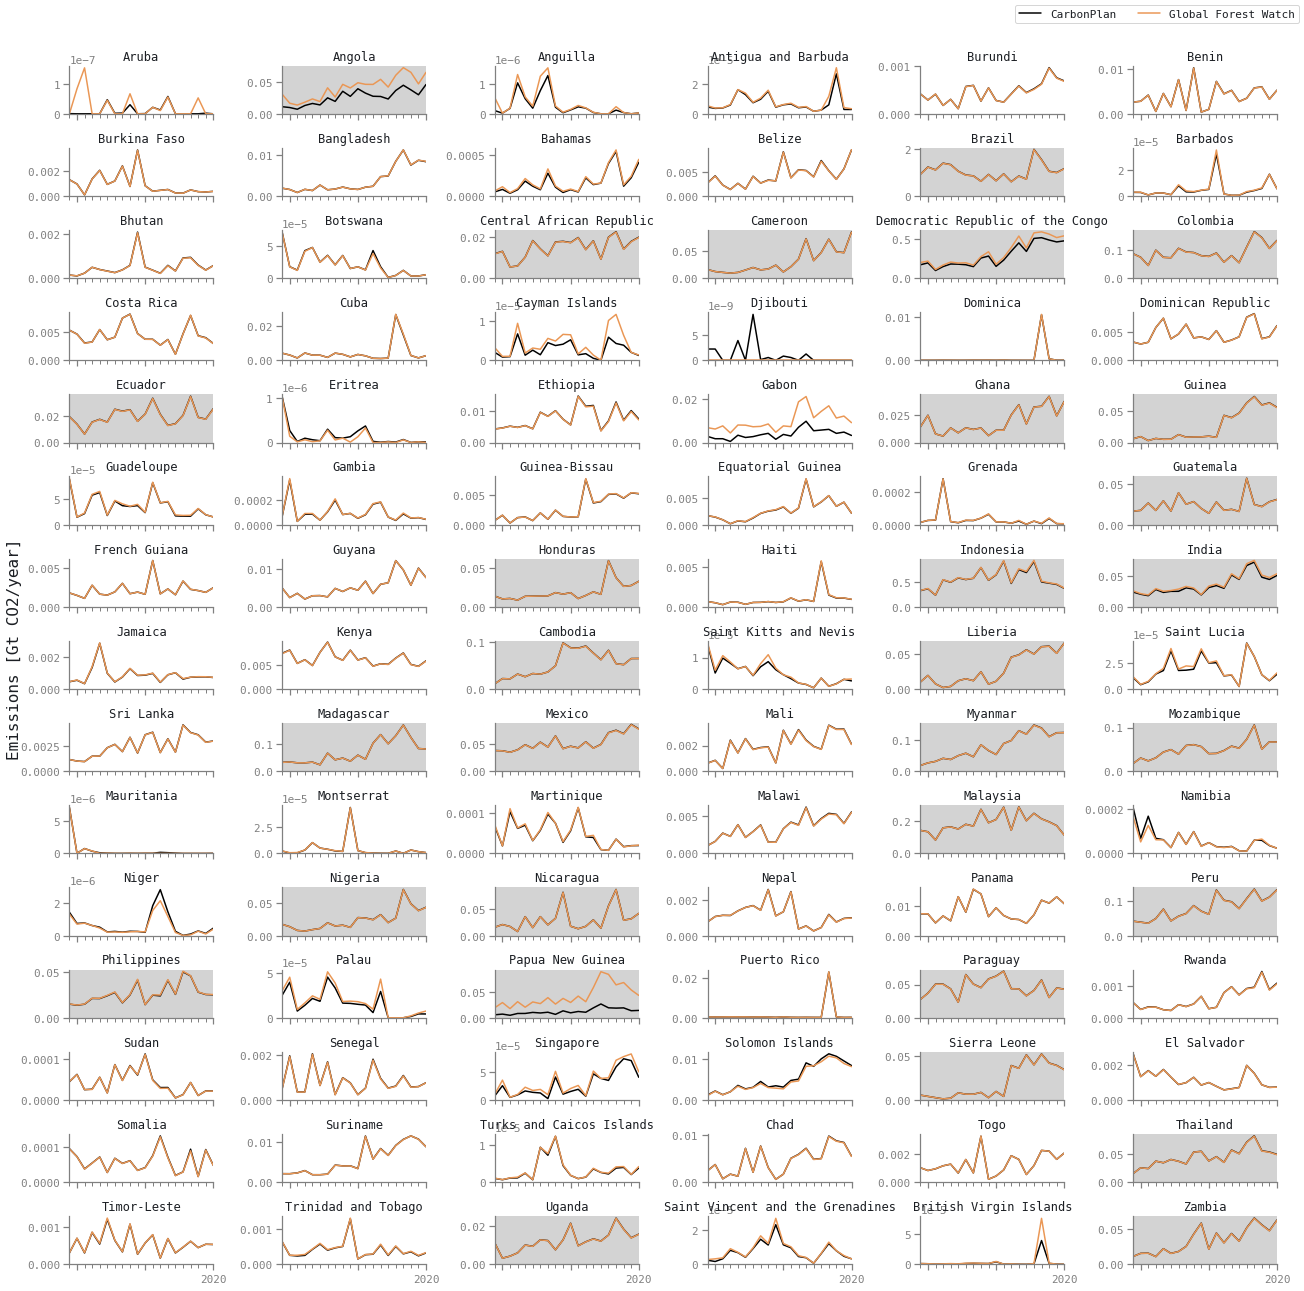

In [16]:
fig = plt.figure(figsize=(18,18))
for (i, (code, country)) in enumerate(tropical_countries):
    plt.subplot(15, 6, i+1, sharex=plt.gca())
#     sub = top_emitters_df.loc[top_emitters_df.iso3_country == country]
    trace_wide['v0.4'][code].plot(ax=plt.gca(), label='CarbonPlan', legend=False, color='black')
    gfw_wide[country].plot(ax=plt.gca(), label='Global Forest Watch', legend=False, color=dark['orange'])
#     fao_data, full_country_name = grab_timeseries(full_fao_fire_data, iso_code=country)
#     fao_data.plot.line(x='Year Code', y='FAOSTAT', ax=plt.gca(), legend=False, color=dark['blue'])
#   
#     sub.plot.line(x='year', y='CarbonPlan Total', ax=plt.gca(), legend=False)
    plt.title(country)
    plt.ylim(0)
#     if i % 6 == 0:
#         plt.ylabel('Fire Emissions\n[Gt CO2/year]')
    plt.xlabel('')
    plt.xticks(ticks=[trace_wide['v0.4'][code].index[1], trace_wide['v0.4'][code].index[10], trace_wide['v0.4'][code].index[-1]])
    if gfw_wide[country].mean() > 0.01:
        plt.gca().set(facecolor = 'lightgrey')
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
# fig.suptitle('Comparison with Global Forest Watch')

fig.subplots_adjust(top=0.95)

plt.gcf().legend(handles, labels, ncol=2, loc='upper right') #bbox_to_anchor = (0.6, 0.98), 

fig.text(0.0, 0.5, 'Emissions [Gt CO2/year]', va='center', rotation='vertical', fontsize=16)

plt.savefig('comparison_gfw_emissions.png', bbox_inches='tight')
plt.show()
plt.close()


## Part 4 - Compare average numbers with Harris 

In [32]:
avg_emissions.index = avg_emissions['alpha3']
for entry in harris['features']:
    country_code = entry['properties']['alpha3']
    emissions = entry['properties']['emissions']
    if emissions is not None:
        avg_emissions.loc[country_code, 'Harris'] = emissions / 1e9 / 20
avg_emissions_nonan = avg_emissions[['v0.4', 'Harris', 'geometry']].dropna()

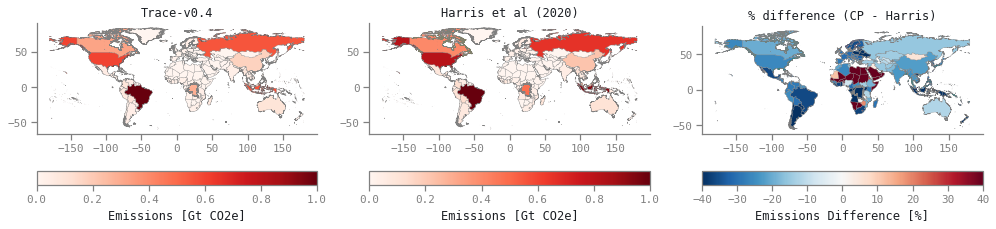

In [34]:
fig, axarr = plt.subplots(ncols=3, figsize=(14,4))
kwargs = dict(
    legend=True,
    legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
    lw=0.25,
    cmap="Reds",
    vmin=0,
    vmax=1,
    ax=axarr[0]
)
avg_emissions_nonan.plot('v0.4', **kwargs)
axarr[0].set_title("Trace-{}".format(version))

kwargs = dict(
    legend=True,
    legend_kwds={"orientation": "horizontal", "label": "Emissions [Gt CO2e]"},
    lw=0.25,
    cmap="Reds",
    vmin=0,
    vmax=1,
    ax=axarr[1]
)
avg_emissions_nonan.plot('Harris', **kwargs)
axarr[1].set_title("Harris et al (2020)".format(version))

kwargs = dict(
legend=True,
legend_kwds={
    "orientation": "horizontal",
    "label": "Emissions Difference [%]",
},
lw=0.25,
cmap="RdBu_r",
vmin=-40,
vmax=40,
ax=axarr[2]
)
avg_emissions_nonan["pdiff"] = (
    (avg_emissions_nonan['v0.4'] - avg_emissions_nonan["Harris"])
    / avg_emissions_nonan["Harris"]
) * 100
avg_emissions_nonan.plot("pdiff", **kwargs)
axarr[2].set_title("% difference (CP - Harris)")
    
plt.tight_layout()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Comparison with Harris et al (2020)')

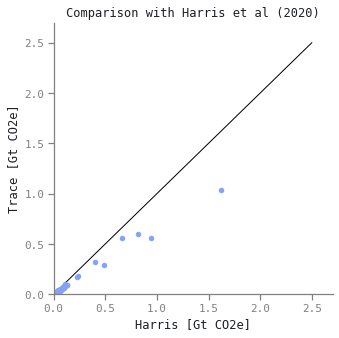

In [35]:
# Scatter Plot
fig, axarr = plt.subplots(figsize=(5,5))
axarr.plot([0, 2.5], [0,2.5], 'k-', lw=1, zorder=0)
avg_emissions.plot.scatter("Harris", 'v0.4', ax=axarr)
axarr.set_ylabel("Trace [Gt CO2e]")
axarr.set_xlabel("Harris [Gt CO2e]")
plt.xlim(0,2.7)
plt.ylim(0,2.7)
axarr.set_title("Comparison with Harris et al (2020)".format(version))


In [ ]:
s3://gfw2-data/climate/carbon_model/gross_emissions/all_drivers/CO2_only/biomass_soil/standard/20210305/00N_000E_gross_emis_CO2_only_all_drivers_Mg_CO2e_ha_biomass_soil_2001_20.tif

In [38]:
tile_id = '00N_070W'
s3://gfw2-data/climate/carbon_model/gross_emissions/all_drivers/all_gases/biomass_soil/standard/forest_extent/per_hectare/20210323/00N_000E_gross_emis_all_gases_all_drivers_Mg_CO2e_ha_biomass_soil_forest_extent_2001_20.tif

In [107]:
harris_tile_path_agb_soil = f'https://gfw2-data.s3.amazonaws.com/climate/carbon_model/gross_emissions/all_drivers/all_gases/biomass_soil/standard/forest_extent/per_hectare/20210323/{tile_id}_gross_emis_all_gases_all_drivers_Mg_CO2e_ha_biomass_soil_forest_extent_2001_20.tif'
harris_tile_path_agb_soil_co2_only = f'https://gfw2-data.s3.amazonaws.com/climate/carbon_model/gross_emissions/all_drivers/CO2_only/biomass_soil/standard/20210305/{tile_id}_gross_emis_CO2_only_all_drivers_Mg_CO2e_ha_biomass_soil_2001_20.tif'
harris_tile_path_soil = f'https://gfw2-data.s3.amazonaws.com/climate/carbon_model/gross_emissions/all_drivers/all_gases/soil_only/standard/20210324/{tile_id}_gross_emis_all_gases_all_drivers_Mg_CO2e_ha_soil_only_2001_20.tif'

In [78]:
lat_s = slice(-7.6, -8)
lon_s = slice(-61.6, -61.2)

In [112]:
import xarray as xr
harris_tile_agb_soil = xr.open_rasterio(harris_tile_path_agb_soil).sel(y=lat_s, x=lon_s)
harris_tile_agb_soil_co2_only = xr.open_rasterio(harris_tile_path_agb_soil_co2_only).sel(y=lat_s, x=lon_s)
harris_tile_soil =  xr.open_rasterio(harris_tile_path_soil).sel(y=lat_s, x=lon_s)

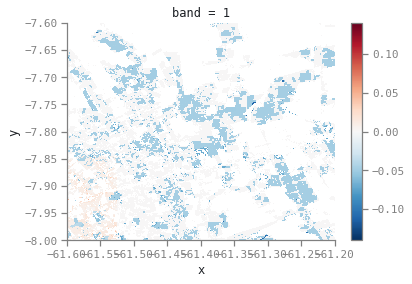

In [113]:
# difference between co2 and other gasses
((harris_tile_agb_soil_co2_only - harris_tile_agb_soil)/harris_tile_agb_soil).plot()

In [114]:
harris_tile_only_forests = (harris_tile_agb_soil - harris_tile_soil)

In [76]:
harris_coarsened = xr.open_zarr(f's3://carbonplan-scratch/harris-emmissions/3000m/{tile_id}.tiff')

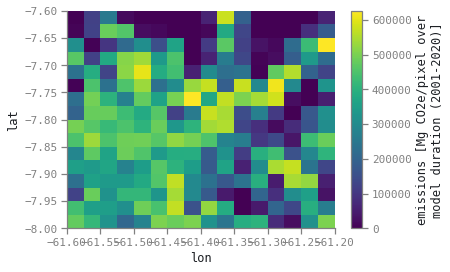

In [90]:
subset_harris = harris_coarsened.sel(lat=lat_s, lon =lon_s).emissions
subset_harris.plot()

In [45]:
cp_tile = xr.open_zarr(f's3://carbonplan-climatetrace/v0.4/tiles/30m/{tile_id}_tot.zarr')

In [84]:
cp_tile_coarsened = xr.open_zarr(f's3://carbonplan-climatetrace/v0.4/tiles/3000m/{tile_id}_tot.zarr')

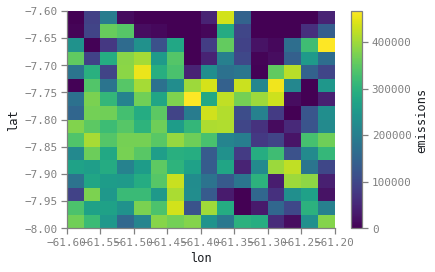

In [89]:
subset_cp = cp_tile_coarsened.sel(lat=lat_s, lon=lon_s).emissions.sum(dim='year')
subset_cp.plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


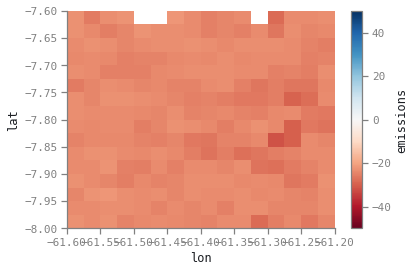

In [95]:
((subset_cp - subset_harris)/subset_harris * 100).plot(vmax=50, vmin=-50, cmap='RdBu')

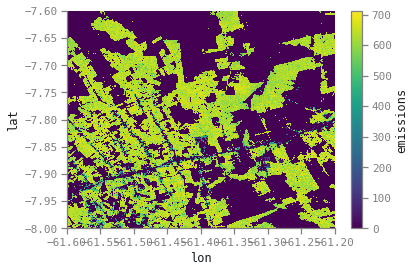

In [74]:
cp_tile.sel(lat=slice(-7.6, -8), lon=slice(-61.6, -61.2)).emissions.sum(dim='year').plot()

## Part 5 - Compare trace_wideglobal emissions timeseries to Global Carbon Project

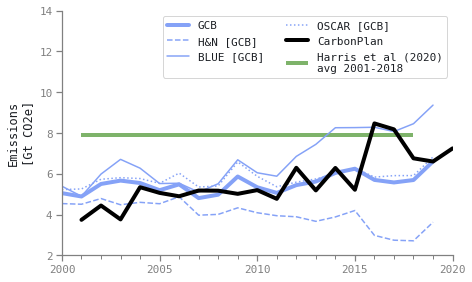

In [21]:
plt.figure(figsize=(7,4.5))
ax = gcp_emissions["GCB"].loc["2000":].plot(label="GCB", lw=4, color=dark['blue'])
for dataset, line_style in zip(["H&N", "BLUE", "OSCAR"], ['--', '-', ':']):
    gcp_emissions[dataset].loc["2000":].plot(label=dataset+' [GCB]', ls=line_style, color=dark['blue'])
# trace_wide['v0.1'].sum(axis=1).plot(ax=ax, label="Trace v0.1".format(version), c="k", lw=3)
trace_wide['v0.4'].sum(axis=1).plot(ax=ax, label="CarbonPlan".format(version), c="k", ls='-', lw=4)
ax.hlines(7.9, xmin='2001', xmax='2018', label="Harris et al (2020)\navg 2001-2018", color=dark['green'], lw=4)
plt.ylabel("Emissions\n[Gt CO2e]")
plt.xlabel('')
plt.legend(ncol=2)
plt.ylim(2,14)
plt.savefig('global_comparisons.png')


## Part 4 - Compare fire emissions from CarbonPlan with those from Blue Sky

In [31]:
bsa = pd.read_csv('global-CO2-estimates-per-vegetation-2015-2020-BSA.csv')

In [32]:
opencanopy = bsa[bsa['parent_class']=='open_canopy_forest'].drop('parent_class', axis=1)

closedcanopy = bsa[bsa['parent_class']=='closed_canopy_forest'].drop('parent_class', axis=1)

merged = pd.merge(opencanopy.rename({'tCO2': 'open_canopy'}, axis=1), 
         closedcanopy.rename({'tCO2': 'closed_canopy'}, axis=1),
         how='left', left_on=['iso3_country','begin_date'],
         right_on=['iso3_country','begin_date'])

In [33]:
merged['total'] = merged['open_canopy'] + merged['closed_canopy']

bsa_comparisons = pd.merge(emissions['Blue Sky'].rename({'tCO2': 'website'}, axis=1),
                           merged.rename({'total': 'slack'}, axis=1),
                           how='left', left_on=['iso3_country','begin_date'],
         right_on=['iso3_country','begin_date'])

In [34]:
bsa_comparisons[bsa_comparisons['iso3_country']=='COD']

,website,iso3_country,begin_date,end_date,open_canopy,end_date_x,closed_canopy,end_date_y,slack
49,6.922832e+08,COD,2015-01-01,2016-01-01,1.211562e+08,2016-01-01,4.968389e+08,2016-01-01,6.179951e+08
256,7.486633e+08,COD,2016-01-01,2017-01-01,1.215563e+08,2017-01-01,5.561352e+08,2017-01-01,6.776915e+08
465,6.773686e+08,COD,2017-01-01,2018-01-01,1.159877e+08,2018-01-01,4.925143e+08,2018-01-01,6.085021e+08
674,6.781723e+08,COD,2018-01-01,2019-01-01,1.143420e+08,2019-01-01,4.966938e+08,2019-01-01,6.110357e+08
881,6.675174e+08,COD,2019-01-01,2020-01-01,1.085527e+08,2020-01-01,4.895868e+08,2020-01-01,5.981395e+08
1088,7.217670e+08,COD,2020-01-01,2021-01-01,1.134957e+08,2021-01-01,5.505704e+08,2021-01-01,6.640661e+08


In [35]:
comparison = pd.merge(emissions['v0.3-fire'].rename({'tCO2eq': 'CarbonPlan'}, axis=1), 
                      emissions['Blue Sky'].rename({'tCO2': 'Blue Sky'}, axis=1),  how='left', left_on=['iso3_country','begin_date'], 
                      right_on = ['iso3_country','begin_date'])

In [36]:
comparison = comparison.drop(['end_date_x', 'end_date_y'], axis=1)
comparison['Blue Sky'] /= 1e9

In [37]:
for dataset in ['CarbonPlan', 'Blue Sky']:
    comparison = comparison.rename({dataset: dataset+' [GtCO2/year]'}, axis=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


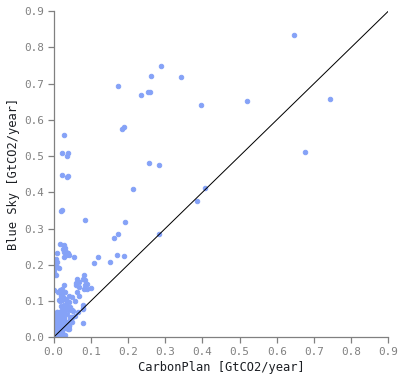

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
comparison.plot.scatter('CarbonPlan [GtCO2/year]', 'Blue Sky [GtCO2/year]', ax=ax)
ax.set_xlim(0,0.9)
ax.set_ylim(0,0.9)
plt.plot([0,1], [0,1], 'k-', lw=1)

In [39]:
## Part 5 - Compare emissions from CarbonPlan with other inventories

In [40]:
inventories_df = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/210623_all_inventory_data.csv")


In [9]:
set(inventories_df['Data source'].values)

{'CAIT',
 'ClimateTRACE',
 'EDGAR',
 'GCP',
 'PIK-CR',
 'PIK-TP',
 'carbon monitor',
 'unfccc',
 'unfccc_nai'}

In [82]:
def select_inventory_timeseries(df, inventory=None, country=None, sector=None):
    if inventory is not None:
        df = df[df['Data source']==inventory]
    if country is not None:
        df = df[df['Country'] == country]
    if sector is not None:
        df= df[df['Sector'] == sector]
    return df

In [86]:
select_inventory_timeseries(inventories_df, country='Brazil', inventory='CAIT', sector='Land-Use Change and Forestry')[[str(year) for year in range(2000, 2019)]]

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
31,1041.43,1105.43,1112.14,1110.98,1112.4,1115.42,1107.64,1118.24,1106.46,1103.36,1118.17,265.75,269.54,264.18,266.89,271.59,392.29,396.51,387.94
